In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import interval_dict, annualize_returns, get_yf_ts, get_usd_mcap, gbm, get_dividends, get_div_return

warnings.filterwarnings('ignore')

This notebook aims to show the components of a forward/futures price of a stock. A forward contract is a legal contract to buy or sell something at a predetermined price for delivery at a specified time in the future. The main difference with a futures contract, is that futures contracts are traded on exchanges guaranteed by clearing houses whereas forwards are not cleared and thus carry a counterparty risk.

Initially futures were traded for agricultural commodities, and later futures contracts were negotiated for natural resources such as oil. Financial futures were introduced in 1972 and now represent the largest portion of futures markets.

A stock/index future is a cash-settled futures contract on the value of that particular stock or index. To fairly price a stock future, we need to consider its current price, the current interest rates of the cash currency and any cash inflows the seller may receive for instance dividends or proceeds from lending the stock.

$$F=S_0 e^{(r-b)T}-\sum_{i=1}^n e^{r(T-t_i)}D_{t_i}$$

To sell a futures contract for an asset, the seller would need to check todays price of the asset and price in any interest they would get on that amount, as if it were cash, with todays view on interest rates curves. Technically the seller of the future can buy the asset today for $S_0$ and deliver it to the buyer at the expiration of the contract in time $T$. The seller of the future would need to borrow cash in amount of $S_0$ in order to buy the asset, on which they would pay an interest rate $r$ to their lender - $S_0e^{rT}$, this term being positive technically transfers the interest rate accrual to the seller.

There are two potential inflows that the seller might receive before the expiry of the contract:
1. The stock might pay dividends $D_{t_i}$, which when paid also accrue with interest rates $r$
2. Proceeds from lending the stock at rate $b$. In the period $T$ other investors might want to borrow the asset, the futures seller can lend the asset at a rate $b$ which in the above equation directly offsets the interest that the seller pays on the initially borrowed cash.

Important to note that these are potential inflows, meaning that unless dividends are confirmed they might not be paid even if strongly projected by analysts, and depending on the market sentiment there might be no borrowing demand for the asset. When there's no borrowing demand the borrow rate converts into a financing cost for the seller, as borrowing cash for finacing a particular stock (depending on its liquidity) will be more expensive. Commonly, the stock itself is provided as collateral to the cash lender.

With that said, a fair futures price $F$ is its spot price $S_0$ acrrued with todays interest rates over the duration $T$ of the future minus any inflows from dividends $D$ or lending $b$. Needless to say, the seller would also add a premium on top in order to make some profit.

In the below plots we observe the spot price of S&P500 index, as well as its 2 month futures price. We observe that the future price of S&P is higher than the spot and this property is called contango. Contango is considered a bullish sign because the market expects that the price of the underlying will rise in the future. The opposite, backwardation is significantly less common and occurs when the futures price is lower than its spot. Showing a squeeze in supply (or significantly increased demand) currently as opposed to contracts maturing in the future.

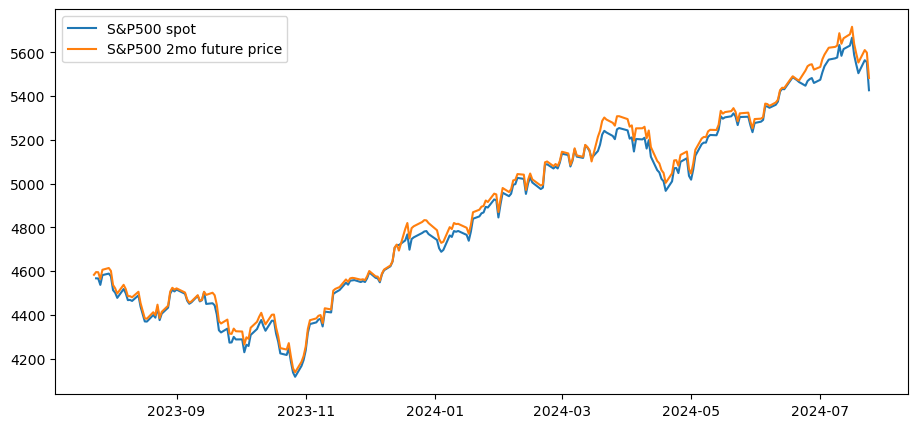

In [2]:
sp500 = get_yf_ts('^GSPC', '1y', '1d')
sp500_2m_f = get_yf_ts('ES=F', '1y', '1d')

plt.figure(figsize=(11,5))
plt.plot(sp500.index.to_timestamp(), sp500['^GSPC'], label='S&P500 spot')
plt.plot(sp500_2m_f.index.to_timestamp(), sp500_2m_f['ES=F'], label='S&P500 2mo future price')
plt.legend()
plt.show()

Unfortunately the data from Yahoo Finance is limited, and we are unable to query futures prices on many liquid indicies or single stocks, also it does not contain projected or dividends announced for the future. For that reason, with a large number of assumptions, we'll approximate some components with the goal to show the mechanics of the futures price formula.

The example we are going to take is for AAPL, we'll use its spot and calculate two futures prices, one expiring in two months and one in one year.

Due to lack of data on IR curves, for a proxy on interest rates, we take the 13 week treasury bill:

In [7]:
rf = get_yf_ts("^IRX", '2y', '1d') / 100 # Expressed in % hence the division

We start with the dividends piece, we'll take the last year dividend returns and assume that they'll be the same for the next period.

In [8]:
spot_date = datetime.date.today()

In [9]:
div_df = get_dividends('AAPL', spot_date.year - 1, spot_date.year - 1)
display(div_df)

,AAPL_DIV,YEAR
Date,,
2023-02-10,0.23,2023
2023-05-12,0.24,2023
2023-08-11,0.24,2023
2023-11-10,0.24,2023


In [84]:
div_return = get_div_return(div_df, 'AAPL', rf)
div_2 = div_return.loc[div_return.index.month <= 2]['AAPL_DIV_EOY'].sum()
div = div_return['AAPL_DIV_EOY'].sum()
print('AAPL annual DIV return: {}'.format(div))

AAPL annual DIV return: 0.9742221518086083


Another strong assumption just for working out a future price, is we assume that the future seller (short) will be able to lend out the asset for the duration of the period at a standard rate of 25bps.

In [16]:
b = 0.0025

Using the spot price, we can then directly calculate a fair value futures price:

In [44]:
futures_fp = lambda S, rf, b, div, T_frac : S * np.exp((rf - b) * T_frac) - div

In [85]:
S = np.round(get_yf_ts('AAPL', '1d', '1d')['AAPL'].iloc[0], 2)
F_exp1 = np.round(futures_fp(S, rf['^IRX'].iloc[-1], b, div_2, 2/12), 2)
F_exp2 = np.round(futures_fp(S, rf['^IRX'].iloc[-1], b, div, 1), 2)

In [86]:
"AAPL spot price ({}) {}, fair futures price in 2 months {} and in 1 year {}, subject to asummptions we made".format(spot_date, S, F_exp1, F_exp2)

'AAPL spot price (2024-07-24) 217.96, fair futures price in 2 months 218.33 and in 1 year 220.66, subject to asummptions we made'

To understand how the future (1y expiration) price changes depending on its components, we plot its fair price with simulated interest rates and borrow (financing rtes):

In [94]:
ffp = pd.DataFrame()
for b in np.linspace(-0.035, 0.035, 51):
    for r in np.linspace(0, 0.1, 51):
        ffp = ffp.append(pd.DataFrame({'F' : futures_fp(S, r, b, div, 1), 'b' : [b], 'r' : [r]}))

Text(0.5, 0, 'Futures price')

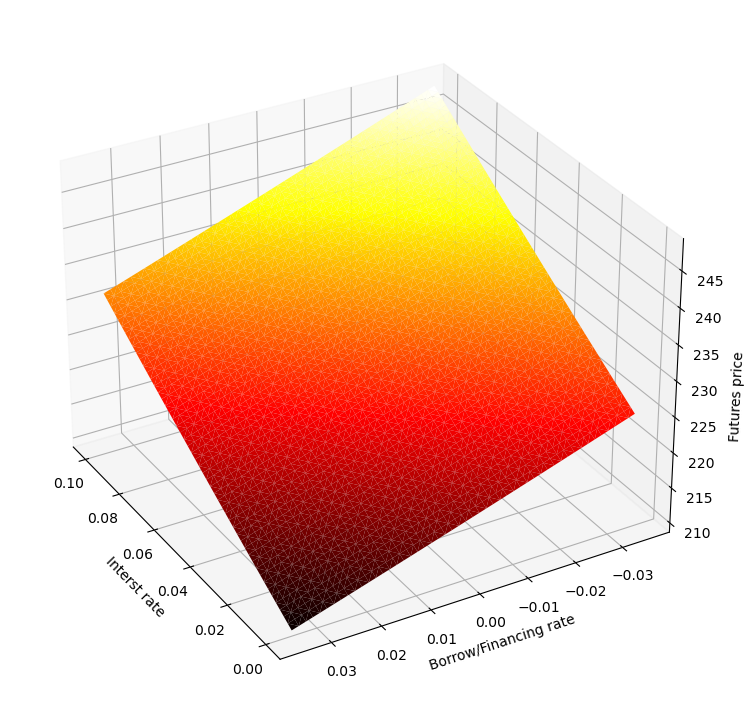

In [95]:
fig = plt.figure(figsize =(11, 9))
ax = plt.axes(projection ='3d')

ax.plot_trisurf(ffp['r'], ffp['b'], ffp['F'], cmap='hot')
ax.view_init(30, 150)
ax.set_xlabel('Interst rate')
ax.set_ylabel('Borrow/Financing rate')
ax.set_zlabel('Futures price')

Typically futures prices are observable on the market and the futures seller would need to mark the rest of the parameters to price it fairly, that works well for liquid instruments and stocks. For stocks that are shorter in supply and less liquid, the spot is replaced with its expectation, so we take an average of the spot and use that in the calculation: $$F = E[S_{t^*}]e^{(r-b)T}-\sum_{i=1}^n e^{r(T-t_i)}D_{t_i}$$

Some methods consider the dividend return as continuous and use that in the exponent, this does not make a difference in the price as long as same dividend return is used, it just misrepresents how dividends are paid. Dividends are discrete and paid on exact ex dates.